# A Variational Autoencoder for Single Cell Transcriptomics in the CELLxGENE Dataset

This notebook complements the source code for a variational autoencoder (VAE) on the CELLxGENE Dataset. It is part of the course "Big Data Praktikum" at Leipzig University. In this notebook, we document our data pipeline and comment on decisions and experiences we made during the implementation. The notebook includes python code for illustrative purposes, but the main training pipeline is contained in seperate python scripts optimized for deployment to HPC infrastructure.

## Background

### Motivation



### Dataset



### Variational autoencoders

In [1]:
from autoCell.data_loader import SingleCellDataset
import src
import cellxgene_census
import anndata
import torch
import pandas as pd
import numpy as np

## Data loading and preprocessing

### Accessing the CELLxGENE Dataset

In [4]:
with cellxgene_census.open_soma() as census:
    adata = cellxgene_census.get_anndata(
        census, 
        "Homo sapiens",
        obs_coords=slice(0, 100),
        obs_value_filter="tissue_general == 'lung' and disease in ['normal','lung adenocarcinoma', 'squamous cell lung carcinoma', 'small cell lung carcinoma', 'non-small cell lung carcinoma', 'pleomorphic carcinoma', 'lung large cell carcinoma'] and is_primary_data == True",  # Specific tissue
        # var_value_filter="feature_name in ['GAPDH', 'ACTB']",  # Specific genes
        obs_column_names=["cell_type", "tissue", "disease"]  # Minimal metadata
    )

print(adata)

The "stable" release is currently 2025-01-30. Specify 'census_version="2025-01-30"' in future calls to open_soma() to ensure data consistency.


AnnData object with n_obs × n_vars = 0 × 61888
    obs: 'cell_type', 'tissue', 'disease', 'tissue_general', 'is_primary_data'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs'


### Preprocessing pipeline

TODO: Describe the data preparation that we've done, point out important code snippets

In [13]:
## Highlights from the preprocessing

In [15]:
## Generatate and describe dataset statistics

### Defining the PyTorch Dataset

In [1]:
from autoCell.data_loader import SingleCellDataset

data_file_path = "data.h5ad"
n_data_samples = 20_000
scale_factor = 1.0
latent_dim = 2
number_of_features = 200
use_variance = True
vae_processing = True

dataset = SingleCellDataset(
        file_path=data_file_path,
        cell_subset=list(range(n_data_samples)),
        log_transform=True, normalize=True,
        scale_factor=scale_factor,
        remove_outliers=[0.05, 0.95],
        select_n_genes=number_of_features,
        use_vae_preprocessing=vae_processing
    )

Using VAE-optimized preprocessing...
Dataset loaded: 20000 cells × 200 genes


In [2]:
import torch

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

## Defining the variational autoencoder

### Architecture

In [11]:
# Here code from the model initialization

### Definition of the ELBO

In [12]:
### Here code for the ELBO

### (Other architectural considerations - if needed)

## Training the variational autoencoder

### Training infrastructure

Describe the WandB setup, describe aspects needed for on-cluster training

### Parameterization of the training

Explain also how to run the script

### Training statistics

Show and interpret some of the charts from WandB

## Evaluation of the latent space

### Obtaining latent representation for the data samples

In [5]:
### Load model, forward pass data, store latent means
from src.vae import CellVAE
import torch

# Define model
model = CellVAE(input_dim=dataset.n_genes, latent_dim=latent_dim, use_variance=use_variance)

# Load weights
model.load_state_dict(torch.load('model.pth', map_location=torch.device('cpu')))

model.eval()

CellVAE(
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
  )
  (z_mean): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
    (1): ReLU()
  )
  (z_logvar): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
    (1): Softplus(beta=1.0, threshold=20.0)
  )
  (decoder_backbone): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=512, bias=True)
    (5): ReLU()
  )
  (value_head): Linear(in_features=512, out_features=200, bias=True)
  (sparsity_head): Linear(in_features=512, out_features=200, bias=True)
)

In [11]:
# obtain latent means on dataset

latent_means = []

with torch.no_grad():
    for idx, data in enumerate(dataloader):
        mu, _ = model.encode(data)
        latent_means.append(mu.numpy())

print(latent_means[:5])


[array([[0., 0.]], dtype=float32), array([[0., 0.]], dtype=float32), array([[0., 0.]], dtype=float32), array([[0., 0.]], dtype=float32), array([[0., 0.]], dtype=float32)]


In [59]:
# dummy latent means while training is in progress:
import numpy as np
import pandas as pd

# Simulate latent means
latent_values = np.random.randn(n_data_samples, latent_dim)

# Create DataFrame for latent values
latent_df = pd.DataFrame(latent_values, columns=[f"z{i+1}" for i in range(latent_dim)])

label_df = dataset.get_cell_metadata()

labeled_latents = pd.concat([label_df.reset_index(drop=True), latent_df], axis=1)

labeled_latents.head()

,tissue,disease,z1,z2
0,lung,normal,-0.330158,1.769522
1,lung,normal,-0.332846,0.303433
2,lung,normal,-0.383342,0.451196
3,lung,normal,1.807764,1.299785
4,lung,normal,0.206052,-0.626402


### Comparison: PCA

Create and compare PCA on Input Data vs Latent Rep.

In [36]:
import scanpy as sc 

adata = dataset.adata.copy()

sc.tl.pca(adata)

/var/folders/j1/w_rpygyd4gjckpxxhlmn1s4w0000gn/T/ipykernel_17134/2549793736.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for label, group in df.groupby(label_col):


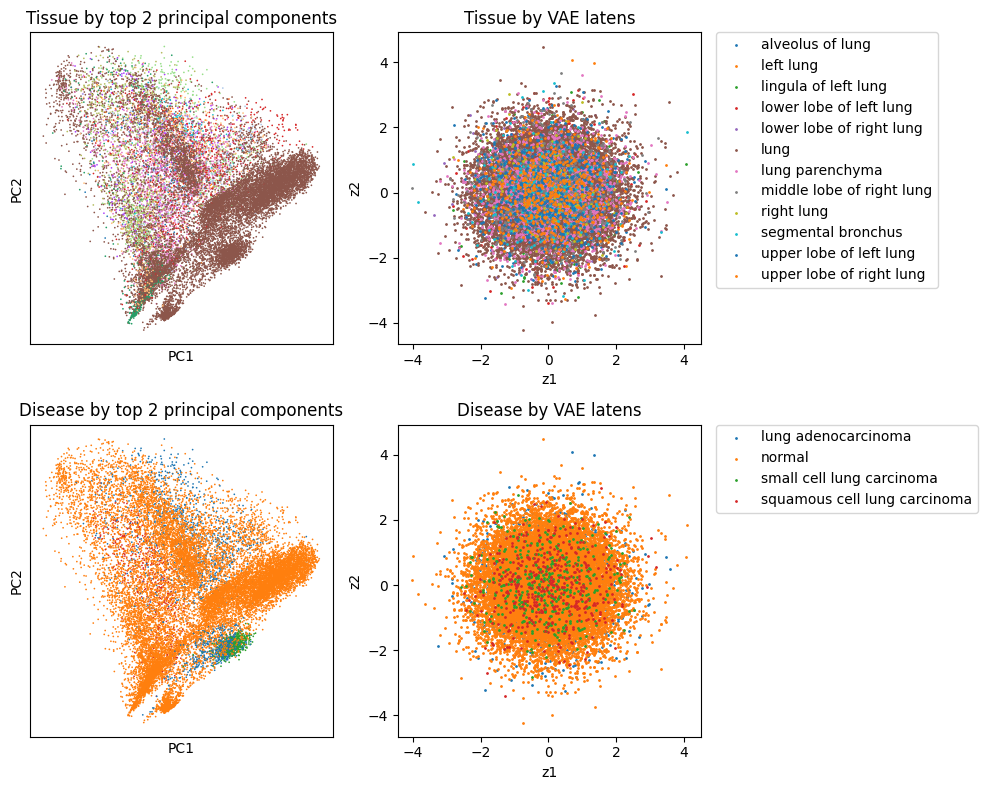

In [72]:
import scanpy as sc
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 8)) 

sc.pl.pca(adata, color=['tissue'], ax=axs[0,0], show=False, title=['Tissue by top 2 principal components'], legend_loc=None)
sc.pl.pca(adata, color=['disease'], ax=axs[1,0], show=False, title=['Disease by top 2 principal components'], legend_loc=None)

def plot_latent_scatter(df, x='z1', y='z2', label_col='label', ax=None, title=None):
    """
    Plots a scatterplot of df[x] vs df[y], colored by df[label_col], on the given Axes.

    Parameters:
        df (pd.DataFrame): Data with latent dimensions and labels
        x (str): Column name for x-axis
        y (str): Column name for y-axis
        label_col (str): Column name for labels
        ax (matplotlib.axes.Axes): Existing Axes object to plot on
        title (str): Optional plot title
    """
    if ax is None:
        ax = plt.gca()

    for label, group in df.groupby(label_col):
        ax.scatter(group[x], group[y], label=label, alpha=1, s=1)

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    if title:
        ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    return ax

plot_latent_scatter(labeled_latents, x='z1', y='z2', label_col='tissue', ax=axs[0,1], title='Tissue by VAE latens')
plot_latent_scatter(labeled_latents, x='z1', y='z2', label_col='disease', ax=axs[1,1], title='Disease by VAE latens')

plt.tight_layout()
plt.show()

### Comparison: UMAP

Create and compare UMAP on Input Data vs Latent Rep.

In [41]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata)

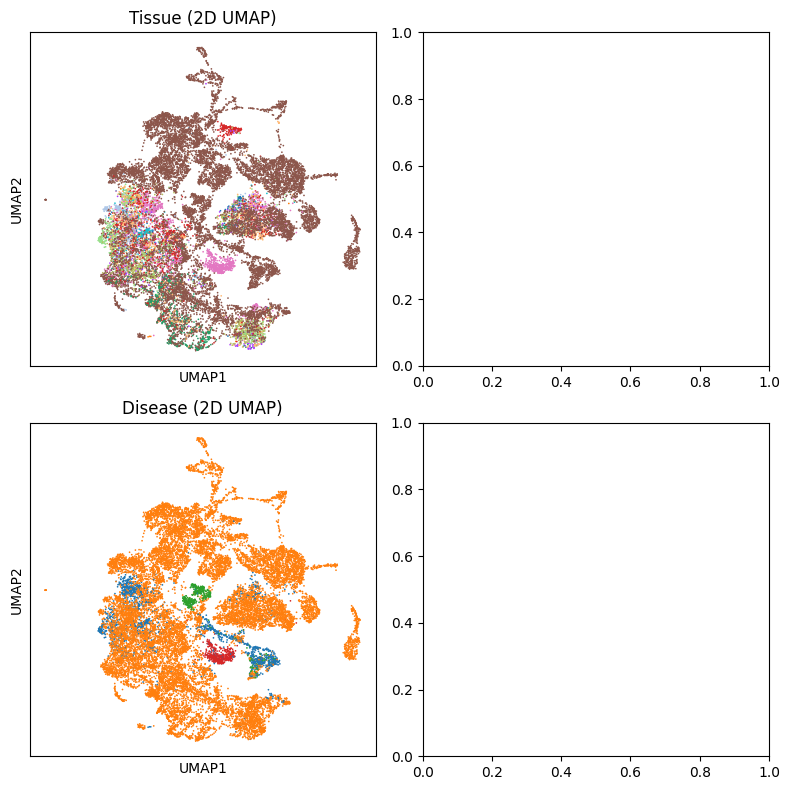

In [42]:
import scanpy as sc
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(8, 8)) 

sc.pl.umap(adata, color=['tissue'], ax=axs[0,0], show=False, title="Tissue (2D UMAP)", legend_loc=None)
sc.pl.umap(adata, color=['disease'], ax=axs[1,0], show=False, title="Disease (2D UMAP)", legend_loc=None)

plt.tight_layout()
plt.show()

### Comparison: PCA + UMAP

Create and compare PCA + UMAP on Input Data vs Latent Rep.

### Latent factor analysis

Vary only individual latents and see effect on cluster-colored umap

## Discussion

Concluding remarks on the results, further steps, ...